In [1]:
import numpy as np
import numpy.linalg as la
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
from scipy.signal import unit_impulse # basis_vector, input: dim, i 
#import itertools
from __future__ import print_function


# discrete cosine transform
# see WT for later:
# http://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families
# https://stackoverflow.com/questions/24536552/how-to-combine-pywavelet-and-opencv-for-image-processing
def Dct2(X):
    '''X: (nx,ny) numpy array'''
    return spfft.dct(spfft.dct(X, norm='ortho', axis=0), norm='ortho', axis=1)

def iDct2(X):
    return spfft.idct(spfft.idct(X, norm='ortho', axis=0), norm='ortho', axis=1)

def compress(X,s):
    '''returns compressed image'''
    N=len(X.reshape(-1))
    ux = Dct2(X).reshape(-1)
    cux = H(s,ux) #compress
    cX = iDct2( cux.reshape(X.shape) )
    
    # precision of dct2
    #print np.linalg.norm( dct2(idct2(X))-X ,'fro')/np.linalg.norm(X,'fro')
    # print error
    print( la.norm(cX-X,'fro')/la.norm(X,'fro') )
    return cX

def pltPic(X):
    plt.figure(1)
    plt.imshow(X,cmap="hot")
    plt.show()

def pltDctPic(UX):
    pltPic(iDct2(UX))

def L(s,x):
    '''returns s abs-largest inices of vector x'''
    # np.argpartition faster than heapq.nlargest because it returns an unsorted list
    # heapq.nlargest(s, zip(x, itertools.count()))
    return np.argpartition(abs(x),-s)[-s:]   

def cL(s,x):
    '''returns n-s abs-smallest inices of vector x'''
    ns = len(x)-s
    return np.argpartition(abs(x),ns)[:ns]    

def H(s,x):
    '''takes vector x, returns hard thresholded vector'''
    x.flat[cL(s,x)] = 0
    return x

def randPic(ny,nx,s):
    X = np.random.uniform(0,255,[ny,nx])
    return compress(X,s)    

def getRandMask(N,m):
    '''Random sample of m indices in range(N)'''
    return np.random.choice(N, m, replace=False) 

0.501332153236
Random image:


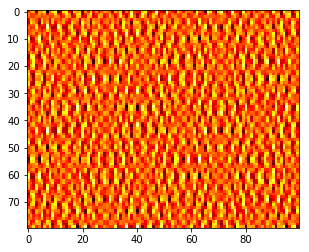

Subsample: (don't know why it gets so dark, but it's just a visualization)


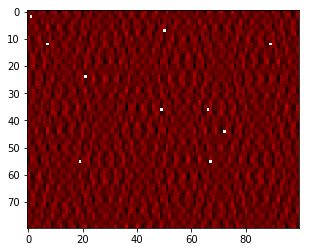

In [2]:
#random image
ny = 80
nx = 100
N = ny*nx
s = 5
m = N-10

X = randPic(ny,nx,s)
mask = getRandMask(N,m) 
y = X.flat[mask]

# create images of mask (for visualization)
Xm = 255 * np.ones(X.shape)
Xm.flat[mask] = X.flat[mask]


print("Random image:")
pltPic(X)

print("Subsample: (don't know why it gets so dark, but it's just a visualization)")
pltPic(Xm)

In [3]:
# IHT in idct2 basis, Version 0.2
# signal: dct2(X), Measurement matrix = mask*idct2

def getA(dims,mask):
    '''Returns m x N measurement matrix A from vector mask containing indices in range(N)'''
    # the columns of A are atomatically normalized
    #A = mask*idct2
    ny, nx = dims
    m = len(mask)
    N = ny*nx
    A = np.zeros([m,N])
    for j in range(m):
        # mask[j]-th basis vector as image matrix
        vj = unit_impulse(N,mask[j]).reshape([ny,nx])
        A[j,:] = iDct2(vj).reshape(N) 
    # get weights
    null = np.zeros(m)
    for c in range(N):
        norm = la.norm(A[:,c])
        if np.isclose(norm,0):
            A[:,c] = null
        else:
            A[:,c] /= norm 
    return A

def IHT(s, A,y, n_max  ):
    ''' Runs IHT on A (given by dims and ri) and y in the idct2 domain'''
        
    x = Dct2(X).reshape(-1)
    norm_x = la.norm(x)
    
    print("Relative error: ", end= ' ')
    #xn = np.dot(A.T,y)
    xn = np.zeros(len(x))
    for n in range(n_max):
        print( "{}, ".format(la.norm(xn-x)/norm_x) , end = ' ')
        cSupp0 = cL(s,xn)
        
        Axn = np.dot(A,xn)
        xn = xn + .5*np.dot(A.T,y - Axn)
        cSupp1 = cL(s,xn)
        xn[cSupp1]=0
     #   if np.all(cSupp0==cSupp1):
     #       print('Converged.')
     #       break
    print(' done.')
    return xn    


In [4]:
A = getA(X.shape,mask)

In [5]:
x_IHT = IHT(s,A,y, 100 )

Relative error:  1.0,  0.633895654426,  0.514113768894,  0.485704965157,  0.481435710326,  0.481900496265,  0.482780913313,  0.483381033936,  0.483720308795,  0.483899431494,  0.483991214905,  0.484037588891,  0.484060860003,  0.484072498367,  0.48407830913,  0.484081207839,  0.484082653237,  0.4840833738,  0.484083732973,  0.484083911995,  0.48408400122,  0.48408404569,  0.484084067852,  0.484084078897,  0.484084084402,  0.484084087145,  0.484084088512,  0.484084089193,  0.484084089532,  0.484084089702,  0.484084089786,  0.484084089828,  0.484084089849,  0.484084089859,  0.484084089865,  0.484084089867,  0.484084089868,  0.484084089869,  0.484084089869,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  0.48408408987,  